In [1]:
# Imports
import torch
torch.cuda.empty_cache()

from hr_dv2.utils import *
from hr_dv2 import tr
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from torchvision.io import read_video

from typing import Tuple, List, Any, TypedDict, TypeAlias

ArrList: TypeAlias = List[np.ndarray]

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

H0, W0 = int(438 * 0.5), int(775 * 0.5)
sub_h: int = H0 % 14
sub_w: int = W0 % 14
H, W = H0 - sub_h, W0 - sub_w


frame_transform = tr.transforms.Compose(
    [
    tr.transforms.Resize((H0, W0)),
    tr.transforms.CenterCrop((H, W)),
    tr.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)


In [2]:
H, W

(210, 378)

In [3]:
raw_video, _, _ = read_video("data/dog_video_half.mp4", output_format="TCHW")
raw_video = raw_video.to(torch.float16)

/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [4]:
transformed_frames = []
for frame in raw_video[:150]:
    frame = frame / 255
    cropped = frame_transform(frame)
    transformed_frames.append(cropped)

/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
subsample_idxs = [i * (len(transformed_frames) // 4) for i in range(5)]
subsample_idxs

[0, 37, 74, 111, 148]

In [6]:
from hr_dv2 import HighResDV2

shifts = [i for i in range(1, 3)]
net = HighResDV2("dinov2_vits14", 4, dtype=torch.float32)
transforms, inv_transforms = tr.get_shift_transforms(shifts, 'Moore')
net.set_transforms(transforms, inv_transforms)
net.half()
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [7]:
n_subsamples = len(subsample_idxs)
subsample_features = np.zeros((n_subsamples, H * W, FEAT_DIM))

for i, j in enumerate(subsample_idxs):
    frame = transformed_frames[j]
    frame = frame.cuda()
    hy_feats, _ = net(frame)
    feat_hr_arr = tr.to_numpy(hy_feats)
    feat_hr_flat = tr.flatten(feat_hr_arr, H, W, net.feat_dim)
    subsample_features[i, :, :] =  feat_hr_flat
    frame = frame.cpu()

Maybe add different dogs to this shared PCA and the FG shared PCA? 

In [8]:
shared_subsample_features = subsample_features.reshape((n_subsamples * H * W, FEAT_DIM))
shared_pca_all = PCA(n_components=3)
shared_pca_all.fit(shared_subsample_features)

PCA(n_components=3)

(79380, 384) (79380,) (10830, 384) 10830
(79380, 384) (79380,) (7636, 384) 7636
(79380, 384) (79380,) (7741, 384) 7741
(79380, 384) (79380,) (13031, 384) 13031
(79380, 384) (79380,) (10887, 384) 10887


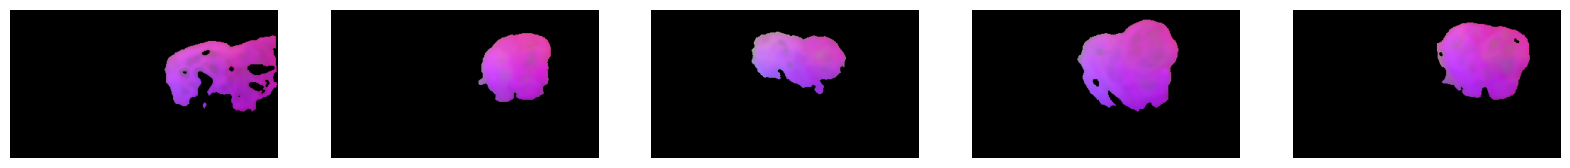

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(20, 8)
fg_feats = []
fg_masks = []

for i, feats in enumerate(subsample_features):
    test = shared_pca_all.transform(feats)
    test = rescale_pca(test)

    m1 = np.where(test[:, 0] > 0.57, 1, 0)
    m2 = np.where(test[:, 2] > 0.57, 1, 0)
    fg_mask = m1 * m2
    #fg_mask = np.reshape(fg_mask, (H * W, 1))
    fg_idxs = np.nonzero(fg_mask)
    fg_feat = feats[fg_idxs]
    print(feats.shape, fg_mask.shape, fg_feat.shape, np.sum(fg_mask))
    fg_feats.append(fg_feat)
    fg_masks.append(fg_mask)

    ax = axs[i]
    ax.set_axis_off()
    ax.imshow(test.reshape(H, W, 3) * fg_mask.reshape(H, W, 1))

In [10]:
def do_shared_pca(feat_list: ArrList, k: int=3) -> Tuple[ArrList, PCA]:
    concat_features = np.concatenate(feat_list, 0)
    shared_pca = PCA(n_components=k)
    shared_pca.fit(concat_features)
    out: List[np.ndarray] = []
    for feat in feat_list:
        shared_repr = shared_pca.transform(feat)
        out.append(shared_repr)
    return out, shared_pca

In [11]:
print(fg_feats[0].shape)
fg_projs, fg_pca = do_shared_pca(fg_feats)

(10830, 384)


(10830, 3)


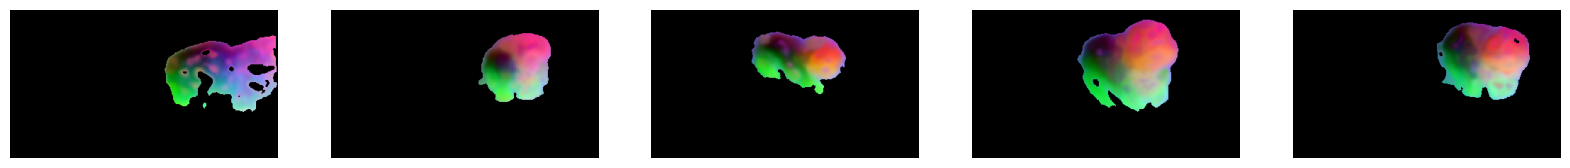

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=5)
print(fg_projs[0].shape)
fig.set_size_inches(20, 10)
for i, feats in enumerate(fg_projs):
    feats = rescale_pca(feats)
    mask = fg_masks[i]
    out = np.zeros((H * W, 3))
    mask = mask.reshape(H * W, 1)
    mask = np.repeat(mask, 3, axis=-1)
    np.place(out, mask, feats)
    ax = axs[i]
    ax.set_axis_off()
    ax.imshow(out.reshape(H, W, 3))

In [24]:
frame_pcas = np.zeros((len(transformed_frames), H, W, 3), dtype=np.float16)

for i, frame in enumerate(transformed_frames):
    if i % 10 == 0:
        print(i)
    frame = frame.cuda()
    hy_feats, _ = net(frame)
    feat_hr_arr = tr.to_numpy(hy_feats)
    feat_hr_flat = tr.flatten(feat_hr_arr, H, W, net.feat_dim)
    frame = frame.cpu()

    test = shared_pca_all.transform(feat_hr_flat)
    test = rescale_pca(test)

    m1 = np.where(test[:, 0] > 0.57, 1, 0)
    m2 = np.where(test[:, 2] > 0.57, 1, 0)

    fg_mask = m1 * m2

    fg_idxs = np.nonzero(fg_mask)
    fg_feat = feat_hr_flat[fg_idxs]

    fg_proj = fg_pca.transform(fg_feat)
    fg_proj = rescale_pca(fg_proj)

    out = np.zeros((H * W, 3))
    mask = fg_mask.reshape(H * W, 1)
    mask = np.repeat(fg_mask, 3, axis=-1)
    np.place(out, mask, fg_proj)
    out = out.reshape(H, W, 3)
    frame_pcas[i] = out

0
10
20
30
40
50
60
70
80
90
100


In [ ]:
from PIL import Image
for i, img_arr in enumerate(frame_pcas):
    converted = (img_arr * 255).astype(np.uint8)
    img = Image.fromarray(converted, 'RGB')
    img.save(f"frame_data/{i}.png")

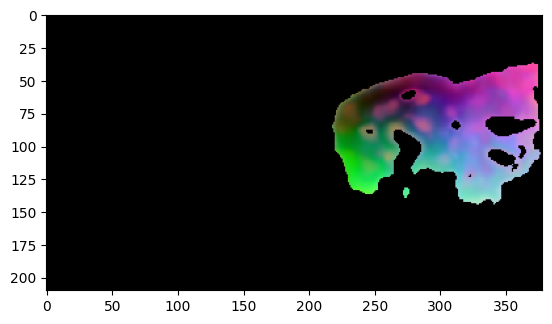

In [21]:
f1 = frame_pcas[0].astype(np.float64)
img = plt.imshow(f1)

In [22]:
img